# **Daftar Isi**
<a name="daftar-isi"></a>

* [Daftar Isi](#daftar-isi)
* [1. Import Dataset](#dataset)
* [2. Exploratory Data Analysis (EDA)](#EDA)
    * [2.1 Analisis General](#analisis-general)
    * [2.2 Distribusi Label](#distribusi-label)
    * [2.3 Sampel](#sampel)
* [3. Data Preprocessing](#data-preprocessing)
    * [3.1 Membuat Class Dataset](#class-dataset)
    * [3.2 Duplikasi Dataset](#duplikat-dataset)
    * [3.3 Menggabungkan Dataset](#combine-dataset)
    * [3.4 Membagi Dataset](#split-dataset)
        * [3.4.1 Data Checking](#check)
* [4. Pengembangan dan Pelatihan Model](#model-development)
    * [4.1 EfficientNet](#EfficientNet)
        * [4.1.1 EfficientNet B0](#b0)
        * [4.1.2 EfficientNet B3](#b3)
        * [4.1.3 Ensemble Model](#model-ensemble)
            * [4.1.3.1 Ensembling Model B0 dan B3](#b03)
    * [4.2 Inisiasi Model](#model-initiation)
    * [4.3 Menggabungkan Model](#model-ensembling)
    * [4.4 Training dan Validating](#model-train)
    * [4.5 Menyimpan Model Terbaik](#save-model)
* [5. Membuat Prediksi](#prediction)
    * [5.1 Load Test Dataset](#test-dataset)
    * [5.2 Evaluasi Model](#model-evaluation)
* [6. Kesimpulan](#conclusion)
* [7. Submission](#submission)
* [8. Referensi](#reference)


# 1. Import Dataset
<a name="dataset"></a>

In [ ]:
import gdown
import zipfile
import os
url = "https://drive.google.com/uc?id=1TbHce2SU-W_Fr2hMjN9E_WhC_1R9M182"
output = 'Penyisiha_Hology_Data_Mining.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile(output, 'r') as zip_ref:
  zip_ref.extractall()
os.remove(output)

Downloading...
From: https://drive.google.com/uc?id=1TbHce2SU-W_Fr2hMjN9E_WhC_1R9M182
To: /content/Penyisiha_Hology_Data_Mining.zip
100%|██████████| 10.2M/10.2M [00:00<00:00, 35.0MB/s]




---



# 2. Exploratory Data Analysis (EDA)
<a name="EDA"></a>

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from sklearn.model_selection import train_test_split
from PIL import Image

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## 2.1 Analisis General
<a name="analisis-general"></a>

In [ ]:
data_info = pd.read_csv('/content/Penyisihan Hology Data Mining/train.csv')

print(data_info)
print("Number of images:", len(data_info))
print("Classes:", data_info['jenis'].nunique(), "jenis and", data_info['warna'].nunique(), "warna")

      id  jenis  warna
0      1      1      1
1      2      0      2
2      3      1      3
3      4      1      1
4      5      0      4
..   ...    ...    ...
772  773      0      1
773  774      0      1
774  775      1      3
775  776      0      0
776  777      0      3

[777 rows x 3 columns]
Number of images: 777
Classes: 2 jenis and 5 warna


## 2.2 Distribusi Label
<a name="distribusi-label"></a>

Unique values and counts for 'jenis':
jenis
0    476
1    301
Name: count, dtype: int64

Unique values and counts for 'warna':
warna
3    234
2    162
4    140
1    125
0    116
Name: count, dtype: int64


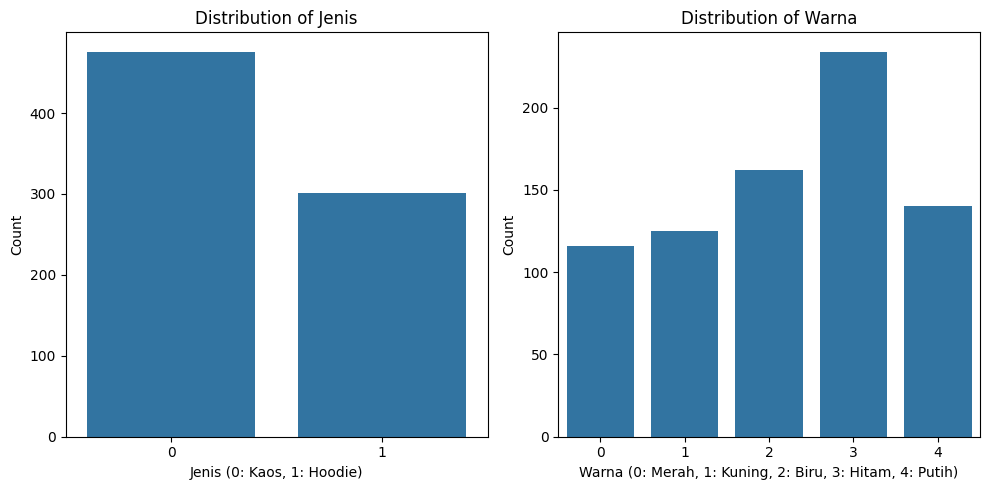

In [ ]:
# Display unique values and their counts
print("Unique values and counts for 'jenis':")
print(data_info['jenis'].value_counts())

print("\nUnique values and counts for 'warna':")
print(data_info['warna'].value_counts())

# Plotting
plt.figure(figsize=(10, 5))

# Countplot for 'jenis'
plt.subplot(1, 2, 1)
sns.countplot(x='jenis', data=data_info)
plt.title('Distribution of Jenis')
plt.xlabel('Jenis (0: Kaos, 1: Hoodie)')
plt.ylabel('Count')

# Countplot for 'warna'
plt.subplot(1, 2, 2)
sns.countplot(x='warna', data=data_info)
plt.title('Distribution of Warna')
plt.xlabel('Warna (0: Merah, 1: Kuning, 2: Biru, 3: Hitam, 4: Putih)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## 2.3 Sampel
<a name="sampel"></a>

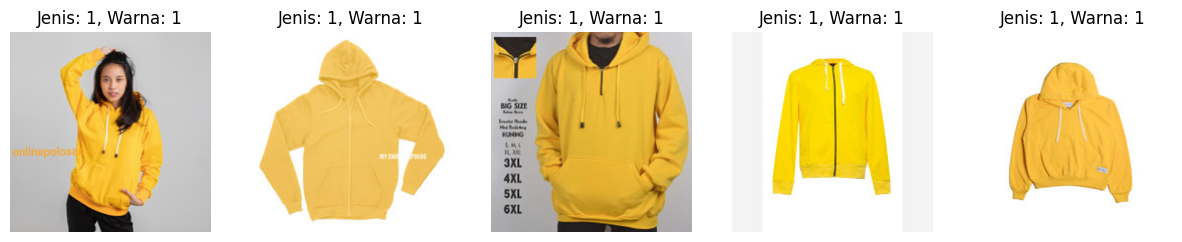

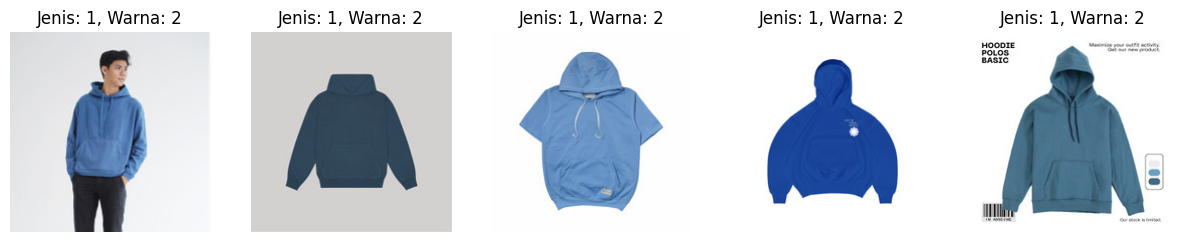

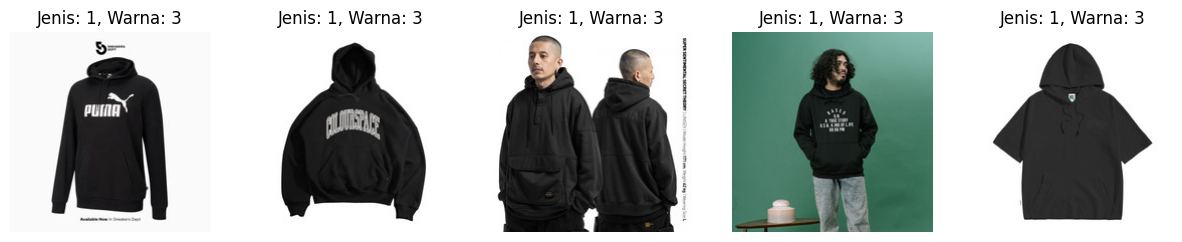

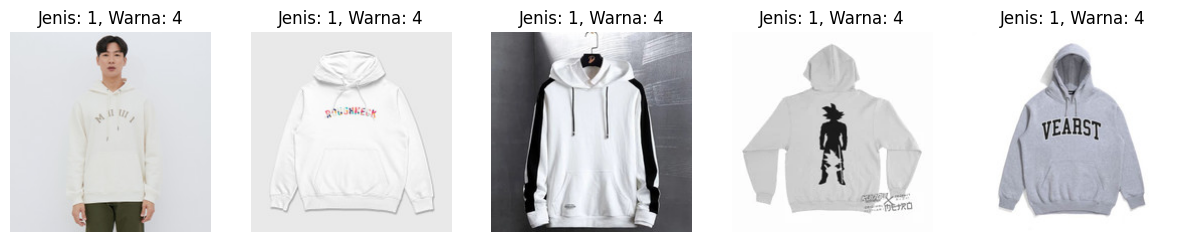

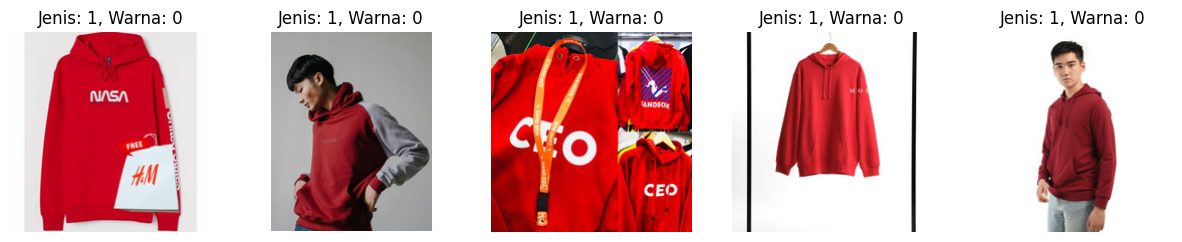

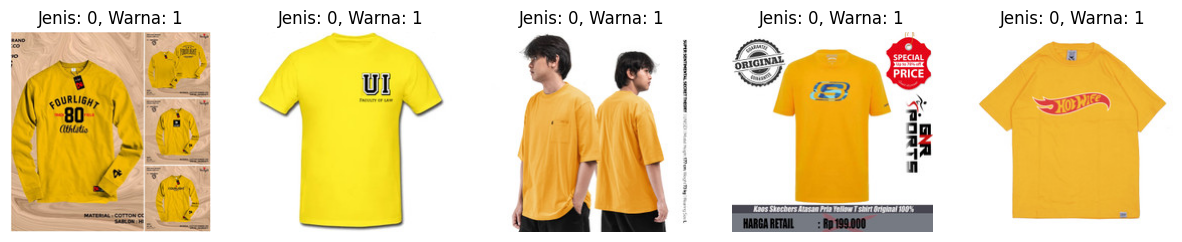

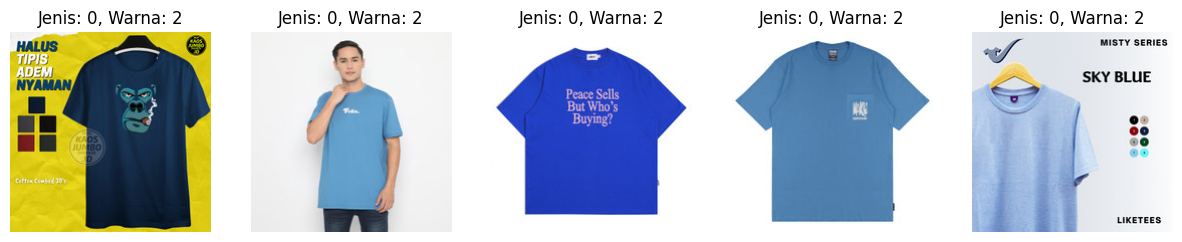

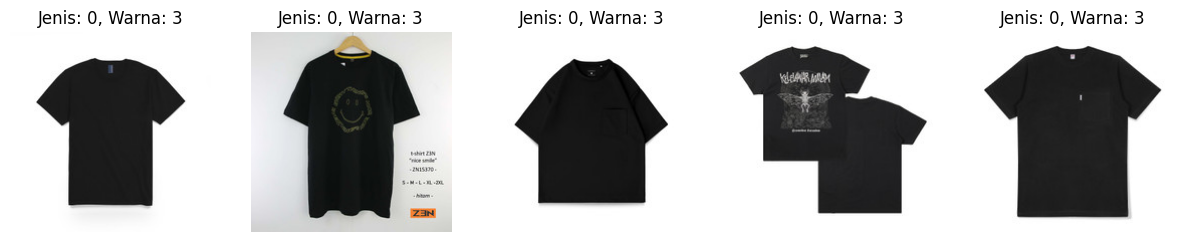

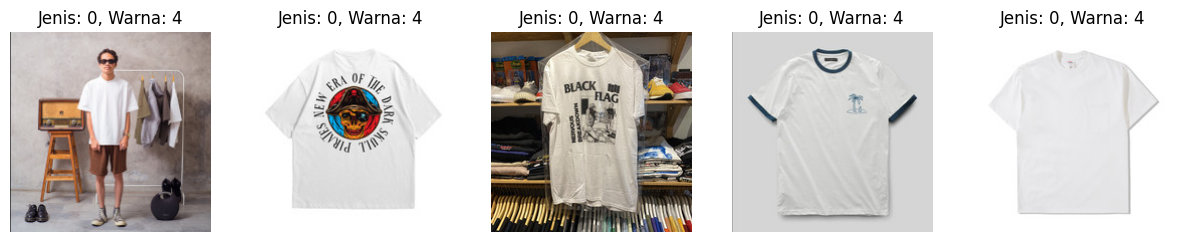

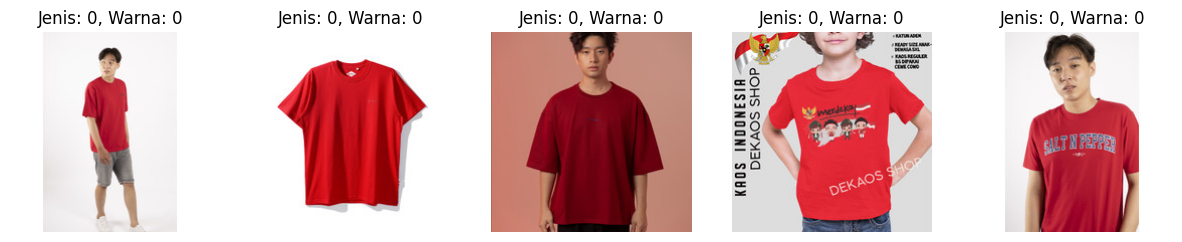

In [ ]:
import random

def show_samples(data_info, num_samples=5):
    for jenis_class in data_info['jenis'].unique():
        for warna_class in data_info['warna'].unique():
            samples = data_info[(data_info['jenis'] == jenis_class) & (data_info['warna'] == warna_class)].sample(num_samples)
            plt.figure(figsize=(15, 3))

            for idx, img_id in enumerate(samples['id']):
                # Check for both .jpg and .png extensions
                img_path = None
                for ext in ['.jpg', '.png']:
                    path = f'/content/Penyisihan Hology Data Mining/train/{img_id}{ext}'
                    if os.path.exists(path):
                        img_path = path
                        break

                if img_path:  # If a valid path is found, open the image
                    img = Image.open(img_path)
                    plt.subplot(1, num_samples, idx+1)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(f"Jenis: {jenis_class}, Warna: {warna_class}")
                else:
                    print(f"Image {img_id} not found in either .jpg or .png format")

        plt.show()

show_samples(data_info)



---



# 3. Data Preprocessing
<a name="data-preprocessing"></a>

## 3.1 Membuat Class Dataset
<a name="class-dataset"></a>

In [ ]:
class ClothesDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        self.data = pd.read_csv(csv_file)  # Load CSV file
        self.img_folder = img_folder  # Image folder path
        self.transform = transform  # Image transformations

    def __len__(self):
        return len(self.data)  # Number of samples

    def _get_image_path(self, img_id):
        # Try both JPG and PNG extensions
        for ext in ['.jpg', '.png']:
            img_name = f"{img_id}{ext}"
            img_path = os.path.join(self.img_folder, img_name)
            if os.path.exists(img_path):  # Check if the image file exists
                return img_path
        return None  # Return None if no file is found

    def __getitem__(self, idx):
        img_id = str(self.data.iloc[idx, 0])  # Get the image ID from the CSV
        img_path = self._get_image_path(img_id)  # Get the image path

        if img_path is None:  # Handle the case where no image is found
            raise FileNotFoundError(f"Image not found for ID: {img_id}")

        # Open the image as a PIL Image
        image = Image.open(img_path).convert('RGB')

        # Extract the labels for jenis and warna
        label_jenis = self.data.iloc[idx, 1]
        label_warna = self.data.iloc[idx, 2]

        # Apply any transforms, if defined
        if self.transform:
            image = self.transform(image)  # Ensure it works with PIL images

        # Return the image and both labels as tensors
        return image, torch.tensor(label_jenis), torch.tensor(label_warna)


## 3.2 Duplikat Train Dataset
<a name="duplikat-dataset"></a>

In [ ]:
from PIL import ImageEnhance

# Sharpening image
class SharpeningTransform:
    def __init__(self, factor=1.5):
        self.factor = factor

    def __call__(self, img):
        return ImageEnhance.Sharpness(img).enhance(self.factor)

# Modified dataset to make it more varied
augment_transform_180 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=180),
    transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=5, shear=5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 1.5)),
    SharpeningTransform(factor=2.0),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Original dataset without augmentation
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

original_dataset = ClothesDataset(
    csv_file='/content/Penyisihan Hology Data Mining/train.csv',
    img_folder='/content/Penyisihan Hology Data Mining/train',
    transform=original_transform
)

augmented_dataset_180 = ClothesDataset(
    csv_file='/content/Penyisihan Hology Data Mining/train.csv',
    img_folder='/content/Penyisihan Hology Data Mining/train',
    transform=augment_transform_180
)

Total number of samples: 1554


## 3.3 Menggabungkan Original Dataset dengan Augmented Dataset
<a name="combine-dataset"></a>


In [ ]:
# Combine all datasets
dataset = ConcatDataset([original_dataset, augmented_dataset_180])

# Check the length of the combined dataset
print(f"Total number of samples: {len(dataset)}")

## 3.4 Membagi Dataset ke Train dan Test
<a name="split-dataset"></a>

In [ ]:
train_indices, val_indices = train_test_split(
    list(range(len(dataset))),  # Indices of the dataset
    test_size=0.2,  # 20% for validation
    random_state=42,  # Reproducibility
    shuffle=True
)

# Create subsets for training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

batch_size = 32  # Batch size for loading data

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### 3.4.1 Cek Visual dan Bentuk dari Gambar
<a name="check"></a>

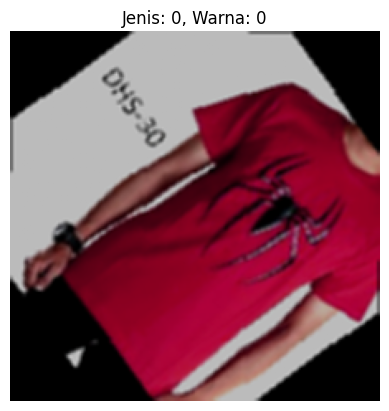

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Ambil satu batch dari data loader
data_iter = iter(train_loader)
images, jenis_labels, warna_labels = next(data_iter)

# Pilih gambar dan label pertama dari batch
image = images[0]
jenis_label = jenis_labels[0].item()  # Convert to scalar
warna_label = warna_labels[0].item()

# Reverse normalization: (x * std) + mean untuk ditampilkan
image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
image = (image * 0.5) + 0.5  # Undo normalization
image = np.clip(image, 0, 1)  # Keep values in [0, 1]

# Tampilkan gambar dan label
plt.imshow(image)
plt.title(f'Jenis: {jenis_label}, Warna: {warna_label}')
plt.axis('off')  # Hide axis for cleaner look
plt.show()

for img, jenis_label, warna_label in DataLoader(dataset, batch_size=4, shuffle=True):
    print(img.shape)  # Should print the correct tensor shape
    print(jenis_label, warna_label)  # Should print the correct labels
    break



---



# 4. Pengembangan dan Pelatihan Model
<a name="model-development"></a>

## 4.1 EfficientNet
<a name="EfficientNet"></a>

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients.

![alt text here](https://blog.roboflow.com/content/images/2024/04/image-1081.webp)

Source : Classification and Understanding of Cloud Structures via Satellite Images with EfficientUNet - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Architecture-of-EfficientNet-B0-with-MBConv-as-Basic-building-blocks_fig3_356981443 [accessed 27 Oct 2024]

### 4.1.1 EfficientNet B0
<a name="b0"></a>

EfficientNet-B0 adalah model deep learning yang dirancang untuk mencapai keseimbangan antara akurasi dan efisiensi komputasi. Model ini memiliki 16 lapisan convolutional dan menggunakan teknik depthwise separable convolutions untuk mengurangi jumlah parameter, sehingga hanya membutuhkan sekitar 5,3 juta parameter—jauh lebih sedikit dibandingkan model seperti ResNet-50 atau Inception-V3. EfficientNet-B0 menerima input gambar berukuran 224x224 piksel dan dilatih menggunakan dataset ImageNet, yang terdiri dari 1,2 juta gambar dengan 1.000 kategori

### 4.1.2 EfficientNet B3
<a name="b3"></a>


EfficientNet-B3 adalah salah satu varian dari keluarga EfficientNet yang didesain untuk meningkatkan akurasi klasifikasi sambil tetap mempertahankan efisiensi komputasi. Model ini memiliki arsitektur yang lebih besar dibandingkan EfficientNet-B0, dengan sekitar 12 juta parameter dan kedalaman jaringan lebih tinggi, memungkinkan pemrosesan fitur yang lebih kompleks. EfficientNet-B3 menerima input gambar berukuran 300x300 piksel dan, seperti varian lainnya, dilatih menggunakan dataset ImageNet dengan 1,2 juta gambar dalam 1.000 kategori."EfficientNet-B0 hanya memerlukan sekitar 5,3 juta parameter, jauh lebih sedikit dibandingkan model seperti ResNet-50, dengan input gambar 224x224 piksel. Meski demikian, model ini mencapai akurasi kompetitif di ImageNet, membuktikan bahwa kombinasi optimal antara kedalaman, lebar, dan resolusi dapat memberikan performa tinggi tanpa mengorbankan efisiensi" (Tan & Le, 2019).

### 4.1.3 Ensemble Model
<a name="model-ensemble"></a>

Ensemble models adalah teknik dalam pembelajaran mesin yang menggabungkan prediksi dari beberapa model untuk meningkatkan performa dan akurasi. Tujuan utama metode ini adalah untuk mengurangi kesalahan model individual (seperti bias dan variansi) dengan menggabungkan kekuatan dari berbagai model. Pendekatan ini didasarkan pada asumsi bahwa beberapa model yang bekerja bersama dapat memberikan hasil yang lebih baik daripada hanya bergantung pada satu model tunggal.



#### 4.1.3.1 Ensembling Model B0 dan B3
<a name="b03"></a>

Menggunakan ensemble model dari EfficientNet-B0 dan EfficientNet-B3 merupakan strategi yang efektif untuk meningkatkan akurasi prediksi sekaligus menjaga efisiensi. Berdasarkan grafik, EfficientNet-B0 memiliki sekitar 5 juta parameter dan mencapai akurasi Top-1 sebesar 77,8%, sementara EfficientNet-B3, dengan 12 juta parameter, mampu mencapai akurasi lebih tinggi yaitu 81,6%. Dengan mengombinasikan kedua model ini dalam ensemble, diperoleh manfaat dari kedua sisi: B0 menawarkan efisiensi komputasi dan prediksi cepat, sedangkan B3 mampu menangkap pola yang lebih kompleks dengan akurasi lebih tinggi. Ensemble model ini juga membantu mengurangi risiko overfitting, karena menggabungkan model sederhana dan kompleks memungkinkan generalisasi yang lebih baik pada data baru. Selain itu, dengan memanfaatkan kekuatan dan perspektif berbeda dari masing-masing model, ensemble ini dapat memperbaiki kelemahan yang ada pada model individual dan menghasilkan prediksi yang lebih stabil serta andal.

![alt text here](https://www.researchgate.net/publication/363887374/figure/fig4/AS:11431281086812866@1664328013046/Number-of-parameters-millions-41.jpg)

Source : Superlative Feature Selection Based Image Classification Using Deep Learning in Medical Imaging - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Number-of-parameters-millions-41_fig4_363887374 [accessed 27 Oct 2024]

## 4.2 Inisiasi Model
<a name="model-initiation"></a>

In [ ]:
from tqdm import tqdm
import copy

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom EfficientNet B0 and B3 Model with Two Outputs (jenis and warna)
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name, num_jenis_classes, num_warna_classes, dropout_prob):
        super(CustomEfficientNet, self).__init__()

        # Select EfficientNet model
        if model_name == "efficientnet_b3":
            self.backbone = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
        elif model_name == "efficientnet_b0":
            self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        else:
            raise ValueError("Invalid model name")

        # Get the number of features from the classifier layer
        num_features = self.backbone.classifier[1].in_features

        # Add a dropout layer before fully connected layers
        self.dropout = nn.Dropout(dropout_prob)

        # Add an intermediate additive fully connected layer to refine features
        self.additive_fc = nn.Linear(num_features, num_features)
        self.relu = nn.ReLU()  # Non-linear activation for the additive layer

        # Separate heads for 'jenis' and 'warna' outputs
        self.fc_jenis = nn.Linear(num_features, num_jenis_classes)
        self.fc_warna = nn.Linear(num_features, num_warna_classes)

        # Remove the original fully connected layer from the backbone
        self.backbone.classifier = nn.Identity()

    def forward(self, x):
        # Pass the input through the backbone
        features = self.backbone(x)

        # Pass through the additive layer with activation
        features = self.additive_fc(features)
        features = self.relu(features)  # Non-linear activation to enhance feature distinctions

        # Generate predictions for both heads
        jenis_out = self.fc_jenis(features)
        warna_out = self.fc_warna(features)

        return {"jenis": jenis_out, "warna": warna_out}


# Instantiate both models
N_jenis, N_warna = 2, 5
model_b3 = CustomEfficientNet("efficientnet_b3", N_jenis, N_warna, dropout_prob=0.7).to(device)
model_b0 = CustomEfficientNet("efficientnet_b0", N_jenis, N_warna, dropout_prob=0.5).to(device)

## 4.3 Menggabungkan Model
<a name="model-ensembling"></a>

In [ ]:
# Define the ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, model_b3, model_b0):
        super(EnsembleModel, self).__init__()
        self.model_b3 = model_b3
        self.model_b0 = model_b0

    def forward(self, x):
        # Forward pass through each model
        outputs_b3 = self.model_b3(x)
        outputs_b0 = self.model_b0(x)

        # Average the predictions for both 'jenis' and 'warna'
        jenis_out = (outputs_b3["jenis"] + outputs_b0["jenis"]) / 2
        warna_out = (outputs_b3["warna"] + outputs_b0["warna"]) / 2

        return {"jenis": jenis_out, "warna": warna_out}

# Instantiate the ensemble model
ensemble_model = EnsembleModel(model_b3, model_b0).to(device)

## 4.4 Training dan Validating
<a name="model-train"></a>

In [ ]:
# Set loss function and optimizer
criterion_jenis = nn.CrossEntropyLoss()
criterion_warna = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=1e-4)

# Early stopping parameters
patience = 4
best_val_loss = float('inf')
best_model_wts = None
epochs_without_improvement = 0
early_stop = False

# Training loop
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct_jenis, correct_warna, total = 0, 0, 0

    for images, label_jenis, label_warna in tqdm(loader):
        images, label_jenis, label_warna = (
            images.to(device),
            label_jenis.to(device),
            label_warna.to(device),
        )

        optimizer.zero_grad()
        outputs = model(images)

        # Compute losses for both labels
        loss_jenis = criterion_jenis(outputs["jenis"], label_jenis)
        loss_warna = criterion_warna(outputs["warna"], label_warna)
        loss = loss_jenis + loss_warna  # Combine the losses

        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        total_loss += loss.item()

        # Calculate accuracy
        _, pred_jenis = torch.max(outputs["jenis"], 1)
        _, pred_warna = torch.max(outputs["warna"], 1)

        correct_jenis += (pred_jenis == label_jenis).sum().item()
        correct_warna += (pred_warna == label_warna).sum().item()
        total += label_jenis.size(0)

    avg_loss = total_loss / len(loader)
    jenis_acc = correct_jenis / total
    warna_acc = correct_warna / total
    return avg_loss, jenis_acc, warna_acc

# Validation loop
def validate(model, loader, device):
    model.eval()
    total_loss = 0
    correct_jenis, correct_warna, total = 0, 0, 0

    with torch.no_grad():
        for images, label_jenis, label_warna in loader:
            images, label_jenis, label_warna = (
                images.to(device),
                label_jenis.to(device),
                label_warna.to(device),
            )

            outputs = model(images)

            loss_jenis = criterion_jenis(outputs["jenis"], label_jenis)
            loss_warna = criterion_warna(outputs["warna"], label_warna)
            loss = loss_jenis + loss_warna

            total_loss += loss.item()

            _, pred_jenis = torch.max(outputs["jenis"], 1)
            _, pred_warna = torch.max(outputs["warna"], 1)

            correct_jenis += (pred_jenis == label_jenis).sum().item()
            correct_warna += (pred_warna == label_warna).sum().item()
            total += label_jenis.size(0)

    avg_loss = total_loss / len(loader)
    jenis_acc = correct_jenis / total
    warna_acc = correct_warna / total
    return avg_loss, jenis_acc, warna_acc

# Main training loop
num_epochs = 15  # Define the maximum number of epochs

for epoch in range(num_epochs):
    # Training step
    train_loss, train_jenis_acc, train_warna_acc = train_epoch(
        ensemble_model, train_loader, optimizer, device
    )

    # Validation step
    val_loss, val_jenis_acc, val_warna_acc = validate(ensemble_model, val_loader, device)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], "
        f"Train Loss: {train_loss:.4f}, Jenis Acc: {train_jenis_acc:.4f}, Warna Acc: {train_warna_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Jenis Acc: {val_jenis_acc:.4f}, Val Warna Acc: {val_warna_acc:.4f}"
    )

    # Early stopping logic (as before)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        best_model_wts = copy.deepcopy(ensemble_model.state_dict())
        print(f"New best model found! Saving model at epoch {epoch + 1}")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}. Restoring best model and continuing training.")
        ensemble_model.load_state_dict(best_model_wts)
        epochs_without_improvement = 0

# Load the best model weights after the entire training loop
ensemble_model.load_state_dict(best_model_wts)

## 4.5 Menyimpan Model Terbaik
<a name="save-model"></a>

In [ ]:
torch.save(ensemble_model.state_dict(), "best_model.pth")

print("Training complete. Best model restored.")



---



# 5. Membuat Prediksi
<a name="prediction"></a>




## 5.1 Load Test Dataset
<a name="test-dataset"></a>

In [ ]:
class TestClothesDataset(Dataset):
    def __init__(self, img_folder, transform=None):
        self.img_folder = img_folder  # Image folder path
        self.img_ids = [f.split('.')[0] for f in os.listdir(img_folder)]  # Extract IDs from filenames
        self.transform = transform  # Image transformations

    def __len__(self):
        return len(self.img_ids)  # Number of samples

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]  # Get the image ID
        img_name = f"{img_id}.jpg"  # Construct the image filename (adjust if needed)
        img_path = os.path.join(self.img_folder, img_name)  # Correct path joining

        # Check if the image exists
        if not os.path.isfile(img_path):
            img_name = f"{img_id}.png"  # Try with .png extension
            img_path = os.path.join(self.img_folder, img_name)  # Correct path joining

            if not os.path.isfile(img_path):  # Check again if the image exists
                print(f"Image not found for ID: {img_id}")
                return None  # or raise an error, or return a placeholder tensor

        # Open the image and convert it to RGB
        image = Image.open(img_path).convert('RGB')

        # Apply any transforms, if defined
        if self.transform:
            image = self.transform(image)

        return image, img_id  # Return the image and its ID

test_dataset = TestClothesDataset(img_folder='/content/Penyisihan Hology Data Mining/test', transform= original_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 5.2 Evaluasi Model dan Membuat Prediksi
<a name="model-evaluation"></a>

In [ ]:
ensemble_model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():  # Disable gradient calculation
    for images, img_ids in test_loader:
        if images is None:  # Skip any None values
            continue

        # Move images to the correct device
        images = images.to(device)

        # Get model outputs (dictionary with 'jenis' and 'warna' keys)
        outputs = ensemble_model(images)
        jenis_outputs, warna_outputs = outputs["jenis"], outputs["warna"]

        # Get the predicted class for both jenis and warna
        _, jenis_preds = torch.max(jenis_outputs, 1)
        _, warna_preds = torch.max(warna_outputs, 1)

        # Collect predictions in a list
        for img_id, jenis, warna in zip(img_ids, jenis_preds, warna_preds):
            predictions.append({
                'id': img_id,
                'jenis': jenis.item(),
                'warna': warna.item()
            })

# Example: Print first few predictions to verify
print(predictions[:5])

# 6. Kesimpulan
<a name="conclusion"></a>

Dalam kompetisi Kaggle ini, kami menghadapi masalah klasifikasi multilabel menggunakan gambar pakaian. Label pertama, 'jenis', membedakan antara 0 (kemeja) dan 1 (hoodie), sedangkan label kedua, 'warna', mencakup kategori warna: 0 (merah), 1 (kuning), 2 (biru), 3 (hitam), dan 4 (putih). Kompetisi ini menggunakan Exact Match Ratio sebagai metrik evaluasi utama.

Untuk mencapai hasil yang kompetitif, kami menerapkan beberapa strategi. Pertama, kami menggunakan augmentasi data untuk meningkatkan keragaman data latih. Selain itu, kami juga menerapkan image sharpening untuk memperjelas fitur dan meningkatkan kinerja model. Kami membangun ensemble model dengan menggabungkan EfficientNet B0 dan EfficientNet B3. Untuk menghindari overfitting, kami menerapkan teknik dropout dan menggunakan early stopping agar pelatihan berhenti ketika performa validasi tidak mengalami peningkatan signifikan.

# 7. Submission
<a name="submission"></a>

In [ ]:
import pandas as pd

# Create a DataFrame from the predictions
predictions_df = pd.DataFrame(predictions)

# Save to CSV
predictions_df.to_csv('pretrainedensemble12.csv', index=False)


# 8. Referensi
<a name="reference"></a>

- Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking model scaling for convolutional neural networks. Proceedings of the 36th International Conference on Machine Learning (ICML). Retrieved from https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet
- Superlative Feature Selection Based Image Classification Using Deep Learning in Medical Imaging - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Number-of-parameters-millions-41_fig4_363887374 [accessed 27 Oct 2024]
- Classification and Understanding of Cloud Structures via Satellite Images with EfficientUNet - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Architecture-of-EfficientNet-B0-with-MBConv-as-Basic-building-blocks_fig3_356981443 [accessed 27 Oct 2024]